In [1]:
from GroundingDINO.groundingdino.util.slconfig import SLConfig
import torch
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util.utils import clean_state_dict
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict
from PIL import Image
from segment_anything import build_sam, SamPredictor 
from GroundingDINO.groundingdino.util import box_ops
import numpy as np


/home/shizijie/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_model_local(config_path, model_path, device='cpu'):
    # Load configuration
    args = SLConfig.fromfile(config_path)
    args.device = device
    # Load model state dictionary
    checkpoint = torch.load(model_path, map_location=device)
    # Build model
    model = build_model(args)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(model_path, log))    
    # Set model to evaluation mode
    _ = model.eval()
    return model

ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "./ShilongLiu/GroundingDINO/groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "./ShilongLiu/GroundingDINO/GroundingDINO_SwinB.cfg.py"
torch.cuda.set_device(1)
device = torch.device("cuda")
groundingdino_model = load_model_local(ckpt_config_filename, ckpt_filenmae,device=device)

/home/shizijie/.local/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: /home/shizijie/experiment/Grounded-Segment-Anything-main/bert-base-uncased
Model loaded from ./ShilongLiu/GroundingDINO/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [3]:
local_image_path = './test_img/input_img/002/right000020.jpg'
TEXT_PROMPT = "tablecloth"
# TEXT_PROMPT = "hand"
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

image_source, image = load_image(local_image_path)

boxes, logits, phrases = predict(
    model=groundingdino_model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[...,::-1] # BGR to RGB

sam_checkpoint = './SAM/sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)
# set image
sam_predictor.set_image(image_source)

/home/shizijie/.local/lib/python3.8/site-packages/transformers/modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/shizijie/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/shizijie/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


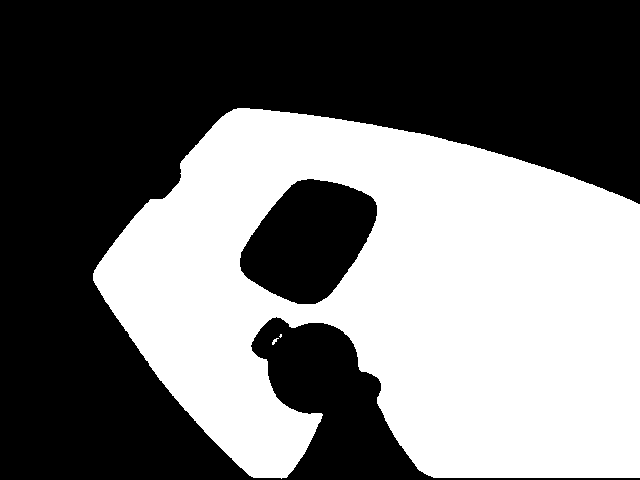

In [4]:
# box: normalized box xywh -> unnormalized xyxy
from GroundingDINO.groundingdino.util import box_ops
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(device)
masks, _, _ = sam_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = transformed_boxes,
            multimask_output = False,
        )
def show_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_cpu = mask.cpu()
    mask_image = mask_cpu.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)
image_mask = masks[0][0].cpu().numpy()
image_mask_pil = Image.fromarray(image_mask)
image_source_pil = Image.fromarray(image_source)
annotated_frame_pil = Image.fromarray(annotated_frame)
annotated_frame_with_mask_pil = Image.fromarray(annotated_frame_with_mask)
image_mask_pil